In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

C:\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
C:\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
C:\anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# 1. 데이터 불러오기
x_iqr = pd.read_csv("x_iqr.csv")
y_iqr = pd.read_csv("y_iqr.csv")

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler
# 학습 : 검증 : 테스트 = 6 : 3 : 1 데이터 분리
X_train, X_valid, Y_train, Y_valid = train_test_split(x_iqr, y_iqr.iloc[:,0], test_size=0.4, random_state=2021)
X_valid, X_test, Y_valid, Y_test = train_test_split(X_valid, Y_valid, test_size=0.25, random_state=2021)

# StandardScaler
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

=============Train=============
Training MSE : 2.580
Training RMSE : 1.606
Training MAE : 1.035
Training MAPE : 1.816
Training R2 : -0.816

=============Test=============
Testing MSE : 3.306
Testing RMSE : 1.818
Testing MAE : 1.219
Testing MAPE : 2.138
Testing R2 : -1.214


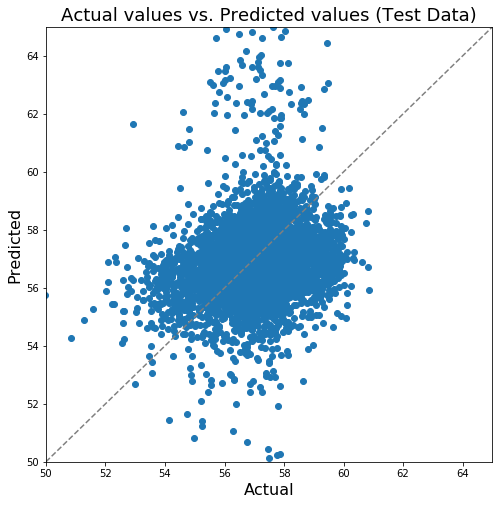

In [6]:
from sklearn.neural_network import MLPRegressor

model_mlp = MLPRegressor().fit(X_train, Y_train)

train_y_pred = model_mlp.predict(X_train)

print('=============Train=============')
print("Training MSE : {:.3f}".format(mean_squared_error(Y_train, train_y_pred)))
print("Training RMSE : {:.3f}".format(np.sqrt(mean_squared_error(Y_train, train_y_pred))))
print("Training MAE : {:.3f}".format(mean_absolute_error(Y_train, train_y_pred)))
print("Training MAPE : {:.3f}".format(mean_absolute_percentage_error(Y_train, train_y_pred)))
print("Training R2 : {:.3f}".format(r2_score(Y_train, train_y_pred)))

test_y_pred = model_mlp.predict(X_test)

print('\n=============Test=============')
print("Testing MSE : {:.3f}".format(mean_squared_error(Y_test, test_y_pred)))
print("Testing RMSE : {:.3f}".format(np.sqrt(mean_squared_error(Y_test, test_y_pred))))
print("Testing MAE : {:.3f}".format(mean_absolute_error(Y_test, test_y_pred)))
print("Testing MAPE : {:.3f}".format(mean_absolute_percentage_error(Y_test, test_y_pred)))
print("Testing R2 : {:.3f}".format(r2_score(Y_test, test_y_pred)))

plt.figure(figsize=(8, 8))
plt.title('Actual values vs. Predicted values (Test Data)', size=18)
plt.scatter(Y_test, test_y_pred)
plt.xlabel('Actual', size=16)
plt.ylabel('Predicted', size=16)
plt.axis([50, 65, 50, 65])
plt.plot([50, 65], [50, 65], color='grey', linestyle='dashed')
plt.show()

In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

torch.manual_seed(0)

In [10]:
class MLP_Regressor(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.layer_1 = nn.Linear(in_features,80)
        self.layer_2 = nn.Linear(80,20)
        self.layer_out = nn.Linear(20, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.05)
        
        torch.nn.init.xavier_uniform_(self.layer_1.weight)
        torch.nn.init.xavier_uniform_(self.layer_2.weight)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.dropout(x)
        x = self.layer_out(x)
        return x    

class Net(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 216)
        self.fc2 = nn.Linear(216, 72)
        self.fc3 = nn.Linear(72, 18)
        self.fc4 = nn.Linear(18, 1)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

In [11]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __getitem__(self, idx):
        self.x_data = torch.FloatTensor(self.x_data)
        self.y_data = torch.FloatTensor(self.y_data)
        return self.x_data[idx], self.y_data[idx]

    def __len__(self):
        return len(self.x_data)
    
class testData(Dataset):    
    def __init__(self, x_data):
        self.x_data = x_data
        
    def __getitem__(self, idx):
        self.x_data = torch.FloatTensor(self.x_data)
        return self.x_data[idx]
        
    def __len__ (self):
        return len(self.x_data)

In [17]:
import collections

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
save_dir = './output'
os.makedirs(save_dir, exist_ok=True)

train_data = CustomDataset(X_train, Y_train.values)
val_data = CustomDataset(X_valid, Y_valid.values)
test_data = testData(X_test)

xtr_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
xvl_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=True)
xts_loader = torch.utils.data.DataLoader(test_data, batch_size=128)

model = Net(in_features=X_train.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)

epochs = 50

base_loss = 100000

model_hist = collections.namedtuple('Model','epoch loss val_loss')
model_loss = model_hist(epoch = [], loss = [], val_loss = [])
try: c = model_loss.epoch[-1]
except: c = 0
for epoch in range(epochs):
    model.train()
    for xt, yt in xtr_loader:
        xt = xt.to(device)
        yt = yt.to(device)
        optimizer.zero_grad()

        y_pred = model(xt)
        loss = criterion(y_pred, yt)      
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    model.eval()
    tot_val_loss = 0
    with torch.no_grad():
        for val_x, val_y in xvl_loader:
            val_x = val_x.to(device)
            val_y = val_y.to(device)
            val_y_pred = model(val_x)
            tot_val_loss += criterion(val_y_pred, val_y).item()

    model_loss.epoch.append(c+epoch)
    model_loss.loss.append(loss.item())
    model_loss.val_loss.append(np.mean(tot_val_loss))
    print(f'Epoch: {epoch}   Train_Loss: {loss.item():.4f}    Val_Loss: {np.mean(tot_val_loss):.4f}')
    if np.mean(tot_val_loss) <= base_loss:
        base_loss = np.mean(tot_val_loss)
        best_model = model.state_dict()
        best_epoch = epoch
        print(f'best_model(epoch:{epoch}) is saved!')
    torch.save(best_model, os.path.join(save_dir, f'Neural_Networks_{best_epoch}.pth'))

C:\Users\octob\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\octob\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\octob\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([93])) that is different to the input size (torch.Size([93, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_

Epoch: 0   Train_Loss: 6.9862    Val_Loss: 1612.3109
best_model(epoch:0) is saved!
Epoch: 1   Train_Loss: 2.5374    Val_Loss: 649.2126
best_model(epoch:1) is saved!
Epoch: 2   Train_Loss: 2.1681    Val_Loss: 571.5656
best_model(epoch:2) is saved!
Epoch: 3   Train_Loss: 2.9622    Val_Loss: 736.5063
Epoch: 4   Train_Loss: 2.4846    Val_Loss: 566.2403
best_model(epoch:4) is saved!
Epoch: 5   Train_Loss: 1.8543    Val_Loss: 473.0851
best_model(epoch:5) is saved!
Epoch: 6   Train_Loss: 2.0268    Val_Loss: 477.8886
Epoch: 7   Train_Loss: 2.2175    Val_Loss: 566.9576
Epoch: 8   Train_Loss: 4.8703    Val_Loss: 941.0386
Epoch: 9   Train_Loss: 2.2679    Val_Loss: 415.7308
best_model(epoch:9) is saved!
Epoch: 10   Train_Loss: 2.6562    Val_Loss: 411.8762
best_model(epoch:10) is saved!
Epoch: 11   Train_Loss: 4.1393    Val_Loss: 481.4084
Epoch: 12   Train_Loss: 4.9184    Val_Loss: 585.2800
Epoch: 13   Train_Loss: 1.0623    Val_Loss: 443.5900
Epoch: 14   Train_Loss: 1.7190    Val_Loss: 366.9320
bes

=============Train=============
Training MSE : 3.734
Training RMSE : 1.932
Training MAE : 1.500
Training MAPE : 2.654
Training R2 : -1.628

=============Test=============
None
Testing MSE : 3.528
Testing RMSE : 1.878
Testing MAE : 1.500
Testing MAPE : 2.680
Testing R2 : -1.362


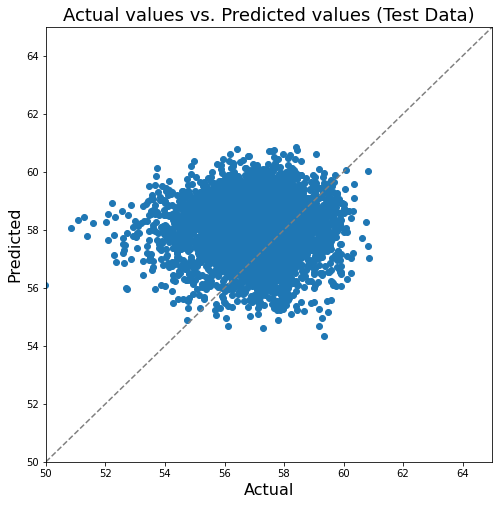

In [18]:
model.load_state_dict(torch.load(os.path.join(save_dir, f'Neural_Networks_{best_epoch}.pth')))

train_y_pred = []
model.eval()
with torch.no_grad():
    for X_batch, y in xtr_loader:
        X_batch = X_batch.to(device)
        prediction = model(X_batch)
        train_y_pred.extend(prediction.cpu().numpy())

test_y_pred = []
model.eval()
with torch.no_grad():
    for X_batch in xts_loader:
        X_batch = X_batch.to(device)
        prediction = model(X_batch)
        test_y_pred.extend(prediction.cpu().numpy())      
        
print('=============Train=============')
print("Training MSE : {:.3f}".format(mean_squared_error(Y_train, train_y_pred)))
print("Training RMSE : {:.3f}".format(np.sqrt(mean_squared_error(Y_train, train_y_pred))))
print("Training MAE : {:.3f}".format(mean_absolute_error(Y_train, train_y_pred)))
print("Training MAPE : {:.3f}".format(mean_absolute_percentage_error(Y_train, train_y_pred)))
print("Training R2 : {:.3f}".format(r2_score(Y_train, train_y_pred)))

print('\n=============Test=============')
print('None')
print("Testing MSE : {:.3f}".format(mean_squared_error(Y_test, test_y_pred)))
print("Testing RMSE : {:.3f}".format(np.sqrt(mean_squared_error(Y_test, test_y_pred))))
print("Testing MAE : {:.3f}".format(mean_absolute_error(Y_test, test_y_pred)))
print("Testing MAPE : {:.3f}".format(mean_absolute_percentage_error(Y_test, test_y_pred)))
print("Testing R2 : {:.3f}".format(r2_score(Y_test, test_y_pred)))

plt.figure(figsize=(8, 8))
plt.title('Actual values vs. Predicted values (Test Data)', size=18)
plt.scatter(Y_test, test_y_pred)
plt.xlabel('Actual', size=16)
plt.ylabel('Predicted', size=16)
plt.axis([50, 65, 50, 65])
plt.plot([50, 65], [50, 65], color='grey', linestyle='dashed')
plt.show()